# *Template Matching* - Descriptores de Color y Textura - Clasificación mediante el método del vecino más cercano

En este tutorial recapitularemos brevemente cómo obtener el histograma de color conjunto y concatenado de una imagen. Posteriormente, se presentará una implementación para obtener el descriptor basado en textura de histograma de Patrones Locales Binarios (LBP por sus siglas en inglés). Finalmente, se desarrollará una implementación del método de clasificación del vecino más cercano, y su variante de $K$ vecinos más cercanos.

## Template Matching

Como ya saben, a través de la cross-correlación podemos identificar estructuras de interés en una imagen. Por ejemplo, al hacer una cross-correlación con un filtro de diferencias finitas, como un filtro de Sobel, podemos identificar bordes verticales y horizontales, ya que estos tendrán una alta intensidad en la imagen resultante de la cross-correlación. Partiendo de esta idea, podemos generalizar este método para identificar no solo bordes, sino cualquier estructura de interés en una imagen. 

A este método se le conoce como *Template Matching* y su algoritmo se puede resumir en los siguinetes pasos:

1. Realizar la **cross-correlación normalizada** entre la imagen en la que se desea buscar una estructura de interés y un recorte de esta.
1. Identificar las intensidades máximas en la imagen resultante de la cross-correlación. Estos máximos corresponderán a los centros de las ventanas en las que se encuentra la estructura de interés. Se puede tomar el máximo global, o varios máximos por encima de un umbral determinado si la estructura se repite varias veces en la imagen.

Note que se hace énfasis en el hecho de que es necesario realizar una cross-correlación normalizada en lugar de una cross-correlación. Esto se debe a que en una cross-correlación común, el sobrelapamiento de dos parches de intensidades altas puede resultar en picos en el mapa de cross-correlación a pesar de que los parches no se asemejen. La definición de la cross-correlación normalizada está dada por la siguiente expresión:

<div>
<img src="attachment:norm_cc.png" width="450"/>
</div>


donde $I_1$ hace referencia a la imagen completa e $I_0$ corresponde al parche de la estructura a identificar. Al normalizar por las varianzas de los parches considerados, hace que los resultados de la correlación entre parches de distintas distribuciones de intensidades y tamaños sean comparables.


Como caso de estudio emplearemos una imagen del minijuego *Wanted* de la versión de Nintendo DS de *New Super Mario Bross*. Este minijuego consiste en identificar rápidamente la cara de un personaje en la pantalla:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import rescale
wanted = imread('wanted.png')
plt.figure(figsize=(6, 4))
plt.title("Tablero de Minijuego Wanted")
plt.imshow(wanted)
plt.axis('Off')
plt.show()

En este caso, quisieramos identificar la ventana en la que se encuentra el rostro de Luigi, por lo que partimos de un recorte de esta sección de la imagen:

In [ ]:
luigi = imread('luigi.png')
plt.figure(figsize=(3, 2))
plt.title("Luigi")
plt.imshow(luigi)
plt.axis('Off')
plt.show()

En este tutorial utilizaremos la función `matchTemplate` de la librería `cv2` para implementar este algoritmo:

In [ ]:
import cv2 as cv
# Se leen las imagenes en escala de grises (indicado con el segundo parámetro en 0)
image = cv.imread('wanted.png', 0)
template = cv.imread('luigi.png', 0)
# Se obtiene el ancho y alto de la plantilla a buscar
w, h = template.shape[::-1]

# Se obtiene el mapa de cross-correlación normalizada mediante la función matchTemplate.
# Se indica que se quiere usar la cross-correlación normalizada indicando en el tercer parámetro
# cv.TM_CCORR_NORMED
res = cv.matchTemplate(image, template, cv.TM_CCORR_NORMED)

# Visualización
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.title("Imagen original")
plt.imshow(image, cmap='gray')
plt.axis('Off')

plt.subplot(132)
plt.title("Estructura de interés")
plt.imshow(template, cmap='gray')
plt.axis('Off')

plt.subplot(133)
plt.title("Mapa de Cross-Correlación Resultante")
plt.imshow(res, cmap='gray')
plt.axis('Off')
plt.show()

Para crear un recuadro en la ventana en la que se encuentra nuestra estructura identificamos el máximo del mapa de cross-correlación y empleamos el ancho y alto de la estructura de interés, extraidos previamente. Sin embargo, note que las dimensiones del mapa de cross-correlación y la imagen original no son las mismas, por lo que es necesario contemplar un borde para obtener las coordenadas máximas en el sistema coordenado de la imagen original:

In [ ]:
from matplotlib.patches import Rectangle

print("Dimensiones de la imagen original")
print(image.shape)
print("Dimensiones del mapa de Cross-Correlación:")
print(res.shape)

# Variables auxiliares para realizar el padding
a = (image.shape[0] - res.shape[0] + 1) // 2
b = (image.shape[1] - res.shape[1] + 1) // 2

# Mapa de cross-correlación con padding
res_pad = np.block([[np.zeros((a, b)), np.zeros((a, res.shape[1])), np.zeros((a, b))],
                    [np.zeros((res.shape[0], b)), res, np.zeros((res.shape[0], b))],
                    [np.zeros((a, b)), np.zeros((a, res.shape[1])), np.zeros((a, b))]])

print("Dimensiones del mapa de Cross-Correlación con margen:")
print(res_pad.shape)

# Se obtiene la coordenada del pixel de más alta intensidad tomando la imagen como un vector de una sola dimension
max_flat = np.argmax(res_pad.flatten())
# Se mapea dicha coordenada a la tupla de coordenadas de la imagen utilizando la función np.unravel_index() (Revisar
# documentación)
max_unravel = np.unravel_index(max_flat, res_pad.shape)

print("Coordenadas del máximo del mapa de cross-correlación:")
print(max_unravel)

# Visualización de resultados
plt.figure(figsize=(15,8))
plt.title("Resultados")
plt.imshow(wanted)
plt.scatter(max_unravel[1], max_unravel[0], marker="*", color="r", s = 100, label= "Máximo del Mapa de Cross-Correlación")
# Consultar la documentación de matplotlib.patches.Rectangle para comprender el orden de los parámetros ingresados
rec = Rectangle((max_unravel[1] - w/2, max_unravel[0] - h/2), w, h, fill=False, color = "r", label= "Ventana Detectada")
plt.gca().add_patch(rec)
plt.axis("Off")
plt.legend()
plt.show()

## Descriptores de Color

En tutoriales pasados se estudió cómo construir los histogramas conjuntos y concatenados de intensidades de color de una imagen para distintos espacios de color. En un contexto de clasificación, podemos pensar estos histogramas como un descriptor de la imagen en un espacio de representación de $N$ dimensiones, donde $N$ es la cantidad de *bins* del histograma. En otras palabras, a través del histograma podemos representar una imagen como un punto en un espacio de $N$ dimensiones.

A continuación, se presentarán dos funciones que permiten obtener el vector asociado a los histogramas conjuntos y concatenados de una imagen a color. Estas funciones son adaptaciones de las presentadas en los tutoriales anteriores, de tal forma que cada una retorna un vector fila asociado al histograma de la imagen recibida por parámetro:

In [ ]:
import numpy as np

def concatenated_histogram(image, bins_per_channel):
    concat_hist = []
    # Para cada canal
    for c in range(image.shape[2]):
        # Se obtiene su histograma
        # El parámetro range se usa para que todos los bins se encuentren distribuidos uniformemente en todo
        # el rango dinámico de cada canal RGB. El parámetro density se usa para obtener el histograma normalizado
        ch_hist, _ = np.histogram(image[:,:,c].flatten(), bins=bins_per_channel, range=(0, 255), density=True)
        
        # Se agrega el histograma del canal a la lista de histogramas de todos los canales
        concat_hist.append(ch_hist)
        
    # Concatenamos los histogramas en un solo arreglo de numpy y le damos forma de un vector fila
    concat_hist = np.concatenate(concat_hist).reshape(1, -1)
    
    return concat_hist

def joint_histogram(image, bins_per_channel):
    
    # Las intensidades de la imagen de dimensiones (m, n, 3) se reordenan en una matriz de dimensiones (3, m x n)
    # para satisfacer los requerimientos de la función histogramdd de numpy
    intensities = np.stack([image[:, :, 0].flatten(), 
                           image[:, :, 1].flatten(),
                           image[:, :, 2].flatten()], axis=1)
    
    # Se obtiene el histograma conjunto y la intersección de rangos asociada a cada bin
    joint_hist, _ = np.histogramdd(intensities, bins = bins_per_channel, range=[(0, 255), (0, 255), (0, 255)], density=True)
    
    # Convertimos el histograma conjunto de dimensiones (bins_per_channel, bins_per_channel, bins_per_channel)
    # en un vector fila de dimensiones (1, bins_per_channel^3)
    
    joint_hist = joint_hist.flatten().reshape(1, -1)
    
    return joint_hist


En el siguiente fragmento de código obtenemos el histograma conjunto y concatenado de una imagen ejemplo, y obtenemos las dimensiones de los histogramas obtenidos:

In [ ]:
from skimage.io import imread
import matplotlib.pyplot as plt

example_1 = imread("starry_night.jpg")
plt.figure()
plt.title("Imagen ejemplo 1")
plt.imshow(example_1)
plt.axis("Off")

print("Dimensiones de la imagen")
print(example_1.shape)

print("Cantidad de bins por canal:")
n = 10
print(n)

print("Dimensiones del histograma concatenado")
con_hist_1 = concatenated_histogram(example_1, 10)
print(con_hist_1.shape)

print("Dimensiones del histograma conjunto")
joint_hist_1 = joint_histogram(example_1, 10)
print(joint_hist_1.shape)

La similitud entre los histogramas de dos imágenes nos da una noción de qué tan parecidas son sus distribuciones de colores. Una medida de la similitud entre dos histogramas es el kernel de intersección, el cual se define a partir de la siguiente expresión:

\begin{equation}
    I(x, y) = \sum_{i=1}^{m} \min{(x_i, y_i)}
\end{equation}

donde $x$ y $y$ son los vectores asociados a los histogramas a comparar y $m$ es la longitud de dichos vectores. A continuación, utilizaremos el kernel de intersección para evaluar qué tan similar es la distribución de color del cuadro "*Noche Estrellada*" con otras dos obras de arte de Van Gogh a partir de sus histogramas concatenados:

In [ ]:
example_2 = imread("wheatfield_with_crows.jpg")
example_3 = imread("girl_in_a_wood.jpg")
images = [example_1, example_2, example_3]

plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title("Imagen Ejemplo " + str(i+1))
    plt.axis("Off")


In [ ]:
# Función para calcular el kernel de intersección
def intersection_kernel(x, y):
    # Se apilan los dos vectores fila
    x_y_stack = np.vstack([x, y])
    # Se calcula el mínimo de cada columna, es decir el mínimo entre cada bin de ambos histogramas
    min = np.amin(x_y_stack, axis=0)
    # Se suman los mínimos
    int_ker = np.sum(min)
    return int_ker

# Se obtienen los histogramas concatenados de las imágenes 2 y 3
con_hist_2 = concatenated_histogram(example_2, n)
con_hist_3 = concatenated_histogram(example_3, n)

print("El Kernel de intersección entre las imágenes 1 y 2 es:")
print(intersection_kernel(con_hist_1, con_hist_2))
print("El Kernel de intersección entre las imágenes 1 y 3 es:")
print(intersection_kernel(con_hist_1, con_hist_3))

El kernel de intersección entre las imágenes 1 y 2 es mayor que el de las imágenes 2 y 3. Esto nos indica, como era de esperarse, que la distribución de colores entre la 1 y 2 es mayor que entre la 2 y 3.

Por otro lado, siguiendo la noción de que los histogramas son una forma de representar las imágenes como puntos en un espacio de $N$ dimensiones, podemos pensar que los puntos que se encuentran más cerca en este espacio representan imágenes que tienen distribuciones de color más parecidas. Una vez establecida una definición de distancia en este espacio, entre menor sea la distancia entre los puntos mayor será la similitud entre la distribución de colores de sus imágenes. 


## Ejercicio 1:
A continuación, calcularemos la distancia euclídea entre los histogramas de las imágenes anteriores para ver si los resultados son congruentes por lo indicado según el kernel de intersección. Para esto impelmente la funcion de la distancia euclidea en n dimensiones. Es decir, sin previo conocimiento de la cantidad de dimensiones que tendrá cada punto debe realizar el calculo de la distancia.
> **consejo:** para este procedimiento deberia usar unicamente opeaciones entre vectores.




In [ ]:
def nd_euclidean_distance(x, y):
    # YOUR CODE HERE
    raise NotImplementedError()

    

In [ ]:
print("La distancia euclidea entre los histogramas de las imagenes 1 y 2 es:")
print(nd_euclidean_distance(con_hist_1, con_hist_2))
assert np.isclose(nd_euclidean_distance(con_hist_1, con_hist_2),0.016625981892995956,0.2) , 'la distancia entre 1 y 2 debería ser 0.00027642327390622944'
print("La distancia euclidea entre los histogramas de las imagenes 1 y 3 es:")
print(nd_euclidean_distance(con_hist_1, con_hist_3))
assert np.isclose(nd_euclidean_distance(con_hist_1, con_hist_3),0.02684366421151304,0.2) , 'la distancia entre 1 y 3 debería ser 0.000720582308300466'

Note que efectivamente la distancia euclídea entre los puntos representados por los histogramas 1 y 2 es menor a la de los histogramas 1 y 3. Esto es consistente con el hecho de que las imágenes 1 y 2 tengan una distribución de colores más similar.

## Descriptores de Textura

Uno de los descriptores de imágenes basado en textura más comunes es el histograma de textones, el cual fue estudiado en clase.
El procedimiento para obtener este descriptor se puede resumir en los siguientes pasos:

1. Construir un banco de N filtros de diferentes formas y tamaños.
1. Hacer la cross-correlación de todas las imágenes de entrenamiento con todo el banco de filtros.
1. Representar cada pixel como la respuesta a los N filtros del banco.
1. Hacer k-means con la representación de todos los píxeles de entrenamiento y crear un diccionario de textones con los centroides (textones).
1. Para obtener la representación de textones de una nueva imagen, repetir los pasos 2 y 3 con esta imagen, y luego asignar a cada píxel el textón más cercano su representación. A la imagen resultante se le conoce como **mapa de textones**.
1. Hacer un histograma del mapa de textones para obtener un **histograma de textones**.

El histograma de textones representa a la imagen como un punto en un espacio cuyas dimensiones indican la repetición de la textura asociada a un textón en la imagen.

Teniendo en cuenta que obtener el diccionario de textones resultante de un conjunto de entrenamiento grande es computacionalmente costoso, al igual que calcular el histograma de textones de dichas imágenes, se han formulado otras representaciones de textura menos costosas de obtener. Una de ellas es la representación a partir de patrones locales binarios, o LBP por sus siglas en inglés.

El proceso para obtener un mapa de LBP se puede resumir en los siguientes pasos:
1. Para cada píxel, definir una ventana de píxeles vecinos.
1. Para cada píxel perteneciente a la ventana, asignar un 0 si su intensidad es menor a la del píxel central o un 1 si su intensidad es mayor.
1. Agrupar las representaciones resultantes en clases dependiendo de criterios como invarianza rotacional.
1. El mapa de LBP es el resultado de asignar una clase a cada píxel dependiendo de la agrupación anterior.

El proceso de asignación de clase a cada píxel se puede entender mejor a través del siguiente diagrama:

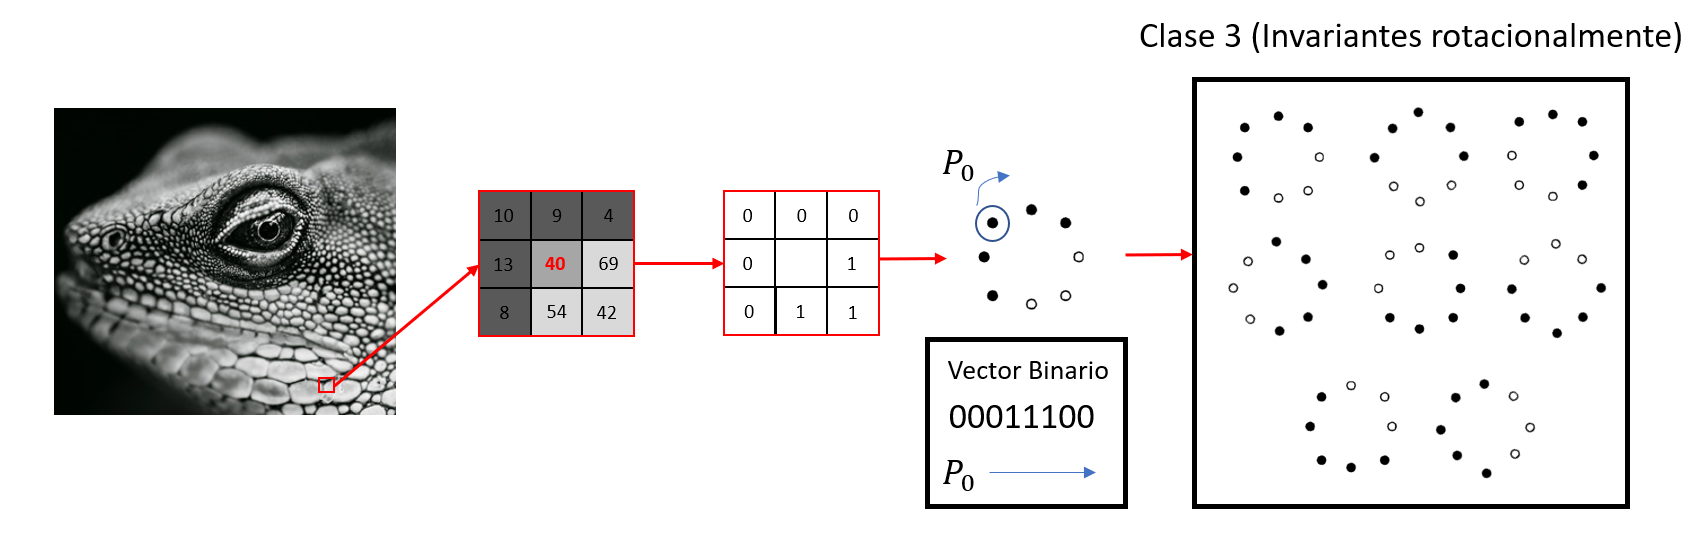



Para simplificar nuestra implementación solo consideraremos una ventana de 3x3 y 10 clases: una clase por cada uno de los 9 patrones uniformes (aquellos que solo tienen una transición entre 1s y 0s), y una clase para todos los patrones no uniformes:

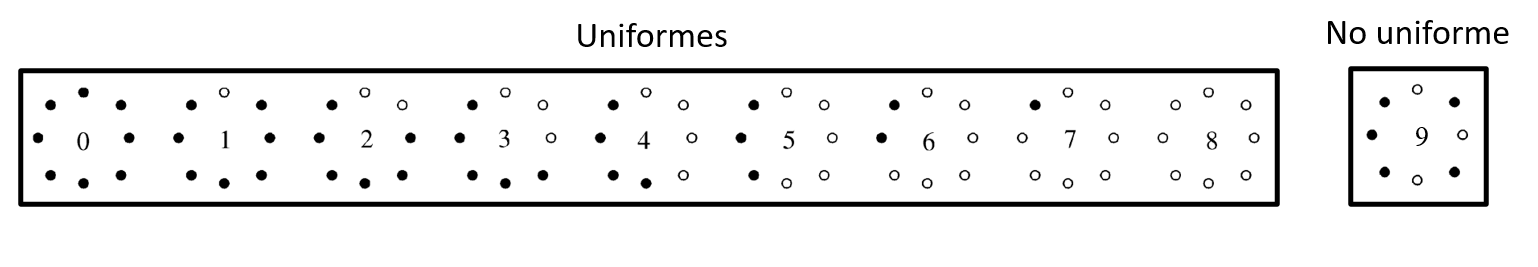

A continuación se presenta una implementación de una función que mapea una ventana a su correspondiente clase de LBP:

In [ ]:
# Esta es una función auxiliar que nos permite saber si el vector binario asociado a una ventana es uniforme o no.
# Lo que hace es que identifica en qué posiciones se da un salto y las marca con 1 (dif_vec). Si hay menos de 3
# saltos el vector está asociado a una ventana uniforme.

def is_uniform(vec):
    dif_vec = np.abs(np.diff(vec))
    return np.sum(dif_vec) < 3

# Esta función recibe una ventana y retorna su clase bajo el modelo de LBP planteado.

def window_to_lbp_class(window, demo=False):
    # Asigna a cada pixel del contorno el valor de 1 o 0 dependiendo de si es mayor o menor al pixel central
    window_bin = (window > window[1,1]).astype(int)
    # Linealiza los píxeles del contorno en un vector binario lineal
    vec = np.hstack([window_bin[0], window_bin[1,2], window_bin[2][::-1], window_bin[1,0]])
    # Revisa si el vector binario resultante es de una ventana uniforme o no
    if is_uniform(vec):
        # Si si lo es, la clase corresponde a la cantidad de 1s del vector
        cls = np.sum(vec)
    else:
        # Si no, se le asocia la clase 9, correspondiente a las ventanas no uniformes
        cls = 9
    
    # Si la función recibe como parámetro demo = True, se pueden visualizar los pasos intermedios de la función
    if demo:
        print("Ventana recibida:")
        print(window)
        print("Ventana umbralizada:")
        print(window_bin)
        print("Vector binario resultante:")
        print(vec)
        print("Clase:")
        print(cls)
    
    return cls

# Visualización del ejemplo con la misma ventana del diagrama inicial

ej_window = np.array([[10, 9,  4 ],
                      [13, 40, 69],
                      [8,  54, 42]])

window_to_lbp_class(ej_window, demo=True)

Note que una ventaja de este método es que para obtener las clases no fue necesario entrenar un modelo de clasificación no supervisada como k-means, reduciendo en gran medida el costo computacional. A continuación, utilizaremos esta función para obtener el mapa de LBP de algunas imágenes de textura aparentemente distinta:

In [ ]:
# ESTE FRAGMENTO DE CÓDIGO PUEDE DEMORARSE UN POCO EN CORRER

# Función que retorna el mapa de LBP de una imagen
def LBP_map(image):
    # Matriz en la que se va a almacenar el mapa de LBP. Se excluyen los bordes de la imagen
    LBP_map = np.zeros((image.shape[0] -1, image.shape[1] -1))
    for i in range(1, image.shape[0] -1):
        for j in range(1, image.shape[1] -1):
            # Para cada pixel que no pertenece al borde, se extrae la ventana de 3x3 centrada en él
            window = image[i-1:i+2, j-1:j+2]
            # Se obtiene la clase asociada a dicha ventana según el método de LBP
            cls = window_to_lbp_class(window)
            # Se asigna la clase al mapa de LBP
            LBP_map[i-1, j-1] = cls
    return LBP_map

from skimage.transform import resize

texture_1 = resize(imread("texture_1.jpg", as_gray=True), (400, 600))
texture_2 = resize(imread("texture_2.jpg", as_gray=True), (400, 600))
texture_3 = resize(imread("texture_3.jpg", as_gray=True), (400, 600))
images = [texture_1, texture_2, texture_3]

plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title("Textura " + str(i+1))
    plt.imshow(images[i], cmap='gray')
    plt.axis("Off")
    
LBP_maps = [LBP_map(img) for img in images]

plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title("Mapa LBP " + str(i+1))
    plt.imshow(LBP_maps[i])
    plt.axis("Off")
plt.show()


Note que la distribución de intensidades entre los mapas de LBP es significativamente distinta entre las 3 texturas. 
## Ejercicio 2:
Ahora, como saben de las clases magistrales lo mas importante es encontrar la distribución que se tienen de cada uno de los tipos de textura para asi describir la imagen. Por esto haremos una funion que nos permita tener un histograma con el numero de bins igual al numero de texturas que haya(10). Ademas este debe ser un histograma normalizado.
Podemos construir un histograma asociado a cada uno de estos mapas:

In [ ]:
# Función que retorna los histogramas de LBP a partir de los mapas
def LBP_histogram(LBP_map):
    # YOUR CODE HERE
    raise NotImplementedError()
    return hist

In [ ]:

assert len(LBP_histogram(LBP_maps[0]).shape) == 1, f'su histograma debería tener una dimension tiene {len(LBP_histogram(LBP_maps[0]).shape)}'
assert len(LBP_histogram(LBP_maps[0])) == 10, f'su histograma debería tener un largo de 10 y tiene {len(LBP_histogram(LBP_maps[0]))}'
assert np.isclose(np.sum(LBP_histogram(LBP_maps[0])),1,0.2), f'su histograma debería estar normalizado, pero su suma es {np.sum(LBP_histogram(LBP_maps[0]))}'
# Lista de los 3 histogramas
LBP_histograms = [LBP_histogram(mp) for mp in LBP_maps]

# Visualización
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1, 3, 1 + i)
    plt.title("Histograma de LBP " + str(i + 1))
    plt.xlabel("Clases")
    plt.ylabel("Frecuencia Normalizada")
    plt.xticks(range(10))
    plt.bar(range(10) , LBP_histograms[i])
plt.tight_layout()
plt.show()

Al igual que los histogramas de intensidades de color, estos histogramas permiten representar a la imagen como un punto en un espacio de alta dimensionalidad. En este caso, el espacio tiene 10 dimensiones y cada eje representa la frecuencia normalizada de una clase de LBP en el mapa de la imagen.

## Clasificación Supervisada: Método de Vecino más Cercano (*Nearest Neighbor*)

El método de clasificación mediante el vecino más cercano es un método de clasificación supervisada el cual es útil cuando podemos representar nuestros datos como puntos en un espacio de una o más dimensiones. Los métodos de clasificación supervisada hacen uso de las anotaciones de clasificación sobre el conjunto de entrenamiento. Conceptualmente, el método del vecino más cercano es simple. En el momento de inferencia, es decir cuando queremos clasificar un dato cuya clase desconocemos, se le asigna al nuevo dato la misma clase del punto más cercano del conjunto de entrenamiento.

Para estudiar y poder visualizar cómo funciona este método de clasificación, construiremos una base de datos simplificada. Cada dato estará representado por un punto de 2 dimensiones, el cual podrá pertenecer a una de 4 clases identificadas con las etiquetas "0", "1", "2" y "3". A continuación, construimos una matriz `X_train`, cuyas filas representan las coordenadas de 20 puntos que conformarán nuestro conjunto de entrenamiento. Además, se construirá un vector columna de longitud 20 (`Y_train`), el cual contiene las etiquetas de las clases de cada punto del conjunto de entrenamiento. Posteriormente se graficarán estos puntos con colores asociados a su clase en un espacio de 2 dimensiones: 

In [ ]:
# Semilla para garantizar replicabilidad del código
np.random.seed(21)
# Creación de una matriz de dimensiones (20,2) conformada por números elegidos uniformemente entre 0 y 10
X_train = np.random.uniform(low=0, high=10, size=(20,2))
# Creación de un vector columna de longitud 20 conformado por números enteros elegidos uniforemente entre 0 y 3
Y_train = np.random.choice(4, size=(20,1)).reshape(-1,1)

# Visualización de los arreglos resultantes
print("La matriz de features (X_train) se ve de la siguiente forma:")
print(X_train)
print("El vector de etiquetas (Y_train) se ve de la siguiente forma")
print(Y_train)

# Visualización de los datos en un espacio de 2 dimensiones
plt.figure(figsize=(15,8))
plt.title("Conjunto de Entrenamiento")
plt.scatter(X_train[:,0], X_train[:,1], marker="*", s=100, c=Y_train)
plt.xlim([0,11])
plt.ylim([0,11])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Otra forma de visualizar cómo funciona la clasificación mediante el método del vecino más cercanos es a través del diagrama de Voronoi asociado a los puntos del conjunto de entrenamiento. En el tutorial anterior habíamos empleado el diagrama de Voronoi para visualizar cómo los datos eran clasificados según el centroide más cercano en el método de k-means. Recapitulando, el diagrama de Voronoi demarca las regiones en las que todos los puntos tienen el mismo punto de entrenamiento más cercano. A continuación, se visualiza el diagrama de Voronoi del conjunto de entrenamiento:

In [ ]:
from scipy.spatial import voronoi_plot_2d, Voronoi

fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title("Diagrama de Voronoi de Conjunto de entrenamiento")
ax.scatter(X_train[:,0], X_train[:,1], marker="*", s=100, c=Y_train)
vor = Voronoi(X_train)
voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False)
plt.xlim([0,11])
plt.ylim([0,11])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Para entender cómo funciona la inferencia con el método de vecino más cercano, construiremos un conjunto de prueba de 100 puntos de forma similar a como creamos el conjunto de entrenamiento. Sin embargo, en este caso no contamos con etiquetas de las clases de estos puntos. En el diagrama a continuación se muestran los puntos pertenecientes al conjunto de prueba en color negro:

In [ ]:
X_test = np.random.uniform(low=0, high=10, size=(100,2))

fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title("Conjunto de prueba antes de clasificar")
ax.scatter(X_train[:,0], X_train[:,1], marker="*", s=100, c=Y_train)
ax.scatter(X_test[:,0], X_test[:,1], color="k", label="Conjunto de Prueba")
vor = Voronoi(X_train)
voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False, label="Diagrama de Voronoi - \nConjunto de Entrenamiento")
plt.xlim([0,11])
plt.ylim([0,11])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

A continuación, se presenta una función que implementa inferencia sobre un conjunto de prueba a partir de un conjunto de entrenamiento y usando el método de vecinos más cercanos. Posteriormente, se visualizan los resultados de la inferencia en nuestro conjunto de datos.

In [ ]:
def nearest_neighbor(X_train, Y_train, X_test):
    # Se crea un vector columna de longitud igual a la cantidad de puntos del conjunto de prueba para almacenar
    # las etiquetas inferidas.
    Y_test = np.zeros((X_test.shape[0], 1))
    # Para cada dato del conjunto de prueba:
    for i in range(X_test.shape[0]):
        # Obtener un vector de las distancias entre el dato de prueba y todos los datos de entrenamiento
        dist = np.sum((X_train - X_test[i,:])**2, axis=1)
        # Obtener el índice del valor mínimo del vector de distancias
        arg_min_dist = np.argmin(dist)
        # Obtener la clase del dato asociado a la mínima distancia
        cls_min_dist = Y_train[arg_min_dist, 0]
        # Asignar dicha clase como etiqueta del dato de prueba
        Y_test[i,0] = cls_min_dist
    # Retornar el vector de etiquetas inferidas para el conjunto de prueba
    return Y_test

Y_test = nearest_neighbor(X_train, Y_train, X_test)

# Visualización
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title("Conjunto de prueba clasificado")
ax.scatter(X_train[:,0], X_train[:,1], marker="*", s=100, c=Y_train)
ax.scatter(X_test[:,0], X_test[:,1], c=Y_test)
vor = Voronoi(X_train)
voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False, label="Diagrama de Voronoi - \nConjunto de Entrenamiento")
plt.xlim([0,11])
plt.ylim([0,11])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

 ### K-Nearest Neighbors (KNN)
 
Una variante del método del vecino más cercano es el método de $k$ vecinos más cercanos (KNN por sus siglas en inglés). Como su nombre lo indica, en lugar de considerar la clase del dato de entrenamiento más cercano en el espacio de representación, se tiene en cuenta la clase de los $k$ datos más cercanos. Para asignar una única clase durante inferencia, se elige la clase que tiene mayor frecuencia entre los $k$ datos de entrenamiento más cercanos. Esto se puede interpretar como un sistema de votación, pues es equivalente a que cada uno de los $k$ vecinos votara por su correspondiente clase, y se eligiera aquella con más votos. 

A continuación, se presenta una función que implementa el algoritmo de inferencia mediante KNN. Posteriormente, se visualizan los resultados de la inferencia en nuestro conjunto de datos:

In [ ]:
def k_nearest_neighbor(k, X_train, Y_train, X_test):
    # Se crea un vector columna de longitud igual a la cantidad de puntos del conjunto de prueba para almacenar
    # las etiquetas inferidas.
    Y_test = np.zeros((X_test.shape[0], 1))
    # Para cada dato del conjunto de prueba:
    for i in range(X_test.shape[0]):
        # Obtener un vector de las distancias entre el dato de prueba y todos los datos de entrenamiento
        dist = np.sum((X_train - X_test[i,:])**2, axis=1)
        # Se obtiene el vector de permutación que ordena el vector de distancia en orden ascendente.
        # En otras palabras, el vector sort_permutation contiene los indices del vector original en orden ascendente.
        sort_permutation = dist.argsort()
        # Se utiliza el vector de permutación para reordenar las etiquetas en el orden ascendente de las distancias.
        # Se recomienda leer la documentación del método np.ndarray.argsort() para entender mejor este proceso.
        sorted_labels =  Y_train[sort_permutation, 0]
        # Se eligen las etiquetas de los k puntos a menor distancia
        closest_labels = sorted_labels[0:k]
        # Se obtiene la frecuencia de las clases entre aquellas pertenecientes a los puntos más cercanos
        counts = np.bincount(closest_labels)
        # Se elige como etiqueta final aquella con la mayor frecuencia
        label = np.argmax(counts)
        Y_test[i,0] = label
    # Retornar el vector de etiquetas inferidas para el conjunto de prueba
    return Y_test

Y_test = k_nearest_neighbor(3, X_train, Y_train, X_test)

# Visualización
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title("Conjunto de prueba clasificado con K = 3")
ax.scatter(X_train[:,0], X_train[:,1], marker="*", s=100, c=Y_train)
ax.scatter(X_test[:,0], X_test[:,1], c=Y_test, vmin=0, vmax=3)

## Remover comentario si se quiere visualizar el diagrama de Voronoi para comparar con la clasificación de NN
#vor = Voronoi(X_train)
#voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False, label="Diagrama de Voronoi - \nConjunto de Entrenamiento")

plt.xlim([0,11])
plt.ylim([0,11])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

El método de $k$ vecinos más cercanos se considera como una alternativa más robusta a *outliers* que el método del vecino más cercano. Sin embargo, note que para nuetro conjunto de entrenamiento, conformado por pocos datos muy separados entre sí, este método resulta en inconvenientes como eliminar la clase amarilla. Esto sucede porque datos de entrenamiento que se encuentran proporcionalmente muy lejos de los datos de prueba acaban influyendo en la selección de la clase final.

En este tutorial se estudiaron herramientas para representar imágenes como puntos en un espacio de alta dimensionalidad, y un método de clasificación supervisada para clasificar estos puntos con base en un conjunto de entrenamiento. Al combinar estas dos herramientas, se puede obtener una línea de base para un algoritmo de clasificación supervisada de imágenes basada en su contenido de color o textura.

## Créditos
### Realizado por:
Danniel Moreno
### Supervisado por:
Felipe Escallón Páez - Jose Miguel Abril Nova

2022